In [106]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import re
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [6]:
df=pd.read_csv("Misery_Data.csv")

In [7]:
scores = df['Score'].iloc[:].values

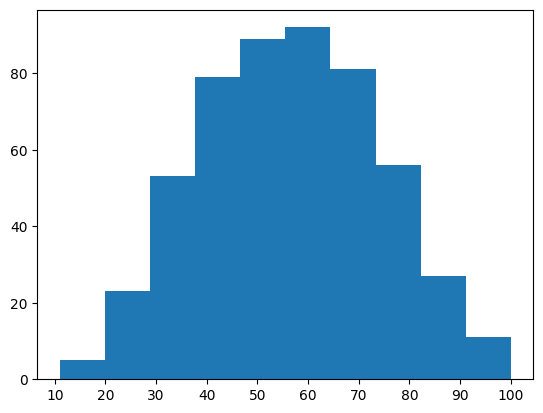

In [8]:
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.hist(scores)
plt.show()

In [9]:
print(f"Min: {min(scores)}, Max:{max(scores)}, Median:{np.median(scores)}, Mean:{round(np.mean(scores),2)}")

Min: 11, Max:100, Median:56.0, Mean:56.45


In [10]:
df['Bucket_10_Cat'] = df['Score'].apply(lambda x: x//10) 

In [11]:
df

,Ep #,Misery,Score,VNTO,Reward,Win,Comments,question_tag,level,Bucket_10_Cat
0,1x01,You Send a Nude Selfie to HR by mistake,70,T,NaN,NaN,NaN,1_base,NaN,7
1,1x01,You find Maggots in your Fried Rice,45,T,NaN,NaN,NaN,1_base,NaN,4
2,1x01,You are Attacked by a bear after Reasoning wit...,52,V,500.0,n,NaN,1_1,higher,5
3,1x01,You Left your Mic On and Went Toilet,49,V,500.0,y,NaN,1_2,NaN,4
4,1x01,You go to a doctor. Doctor Borrows $300k from ...,76,N,NaN,NaN,NaN,2_1_base,NaN,7
...,...,...,...,...,...,...,...,...,...,...
511,3x13,Your Pastor Refers to Women as Penis Homes,50,T,NaN,NaN,NaN,NaN,NaN,5
512,3x13,You're Harassed by a Camel,44,O,NaN,NaN,Audio only clip,but judges saw full video to score,NaN,4
513,3x13,You Get Kicked in the Head by a Train Conductor,51,V,5000.0,y,NaN,NaN,NaN,5
514,3x13,You're Trapped in Your Car for 13 Hours,72,T,10000.0,n,NaN,NaN,NaN,7


In [29]:
cat_10_data = dict()
for i in range(1, 11):
    cat_10_data[i] = []

In [30]:
for _, row in df.iterrows():
    cat = row['Bucket_10_Cat']
    cat_10_data[cat].append(row['Misery'])

In [ ]:
cat_10_data

In [32]:
del cat_10_data[5][cat_10_data[5].index("You're Caught Lying on TV")]

In [33]:
del cat_10_data[1][cat_10_data[1].index("Your Lyft Driver is a Nightmare")]

### Classification

In [34]:
from openai import OpenAI
client = OpenAI()

In [43]:
system_prompt = """You are an expert analyzer of situations. You have experience playing this game show called "Misery" where participants are asked to
rate miserable situations in several ways, like ranking miserable situations, deciding whether a miserable situation falls in-between, above or below two miserable situations, 
and assigning scores to situations. In a similar fashion, your task is to rate miserable situations on a scale of 1-10, where 1 is the least miserable and 10 is most miserable. 

Examples of 1 include: 
Your Lyft Driver is a Nightmare

Example of 5 include:
You're Caught Lying on TV

Examples of 10 include: 
Your doctor's mistake Leaves you paralyzed for life

Given a situation, rate it on a scale from 1 to 10. Do not give any other explanation, reasoning or anything else whatsoever. Your task is to just give a rating from 1 to 10, follow this very strictly.

Situation: 

"""

In [41]:
situations = []
for k,v in cat_10_data.items():
    situations.extend(v)

In [72]:
ground_truth_scores = []
for k,v in cat_10_data.items():
    ground_truth_scores.extend([k for i in range(len(v))])

In [73]:
len(ground_truth_scores)

514

In [42]:
len(situations)

514

In [44]:
model_name = "gpt-3.5-turbo"

ChatCompletionMessage(content='4', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


In [77]:
def get_llm_response(model_name, system_prompt, situations):
    responses = []
    for situ in tqdm(situations): 
        completion = client.chat.completions.create(
          model=model_name,
          messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": situ}
          ]
        )
        responses.append(completion.choices[0].message)
    scores  = [int(re.search("[0-9]+", resp.content).group(0)) for resp in responses]
    return scores

In [48]:
gpt_35_scores = get_llm_response("gpt-3.5-turbo", system_prompt, situations)

In [74]:
accuracy_score(gpt_35_scores, ground_truth_scores)

0.06614785992217899

In [79]:
gpt_4o_mini_scores = get_llm_response("gpt-4o-mini", system_prompt, situations)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 514/514 [03:37<00:00,  2.37it/s]


In [85]:
accuracy_score(gpt_4o_mini_scores, ground_truth_scores)

0.188715953307393

In [86]:
gpt_4o_scores = get_llm_response("gpt-4o", system_prompt, situations)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 514/514 [04:03<00:00,  2.11it/s]


In [87]:
accuracy_score(gpt_4o_scores, ground_truth_scores)

0.21011673151750973

In [91]:
gpt_10_cat_classification_scores = pd.DataFrame({
    "Misery": situations,
    "gpt-4o": gpt_4o_scores, 
    "gpt-4o-mini": gpt_4o_mini_scores, 
    "gpt-3.5-turbo": gpt_35_scores,
    "labels": ground_truth_scores
})

In [93]:
gpt_10_cat_classification_scores.to_csv("gpt_10_cat_classification.csv")

In [94]:
metadata = {
    "system_prompt":  system_prompt
}

In [97]:
json.dump(metadata, open("gpt_10_cat_classification_metadata.json", "w"))

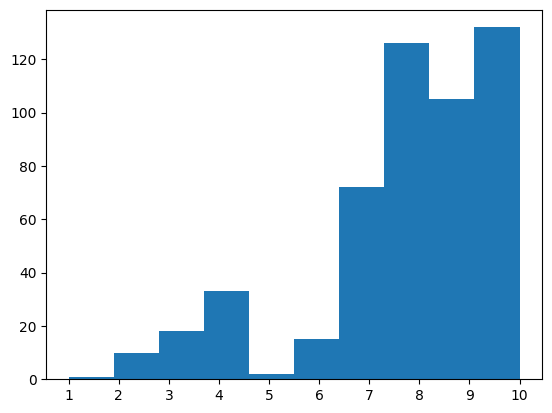

In [100]:
plt.xticks(list(range(1,11)))
plt.hist(gpt_35_scores)
plt.show()

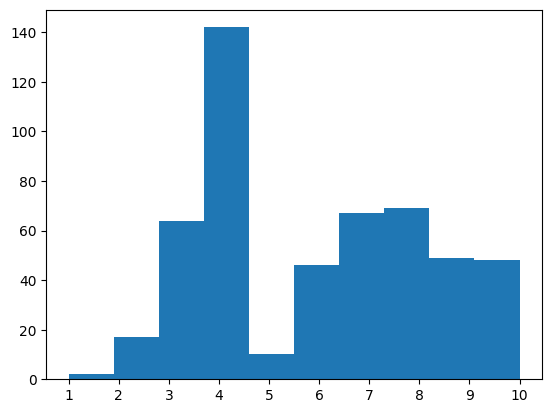

In [101]:
plt.xticks(list(range(1,11)))
plt.hist(gpt_4o_mini_scores)
plt.show()

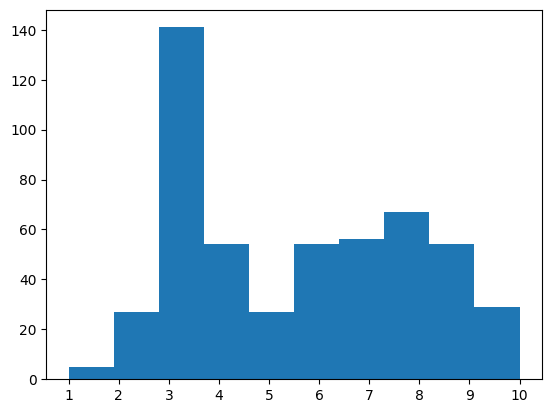

In [102]:
plt.xticks(list(range(1,11)))
plt.hist(gpt_4o_scores)
plt.show()

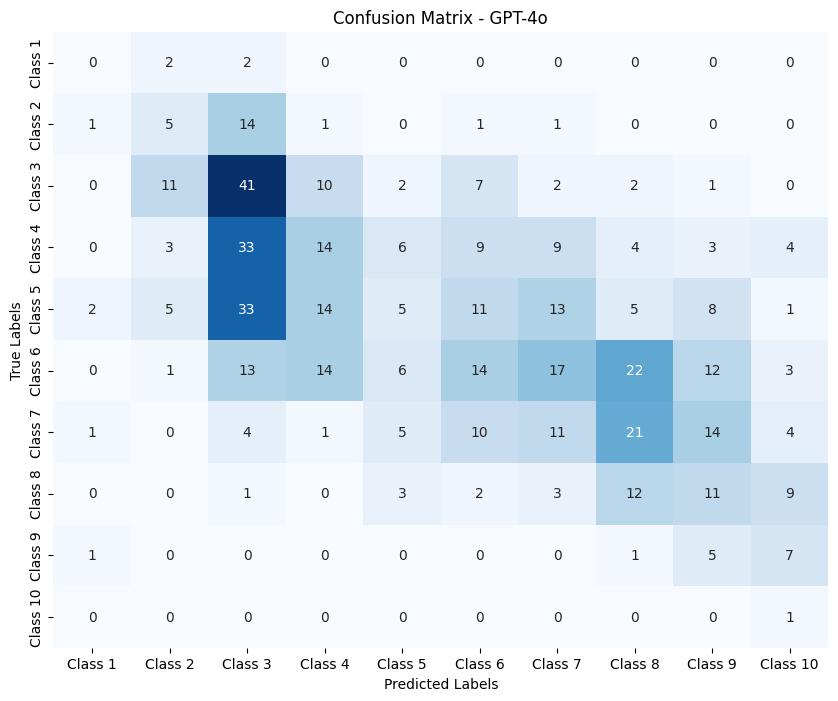

In [108]:
cm = confusion_matrix(ground_truth_scores, gpt_4o_scores)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[f"Class {i}" for i in range(1, 11)], 
            yticklabels=[f"Class {i}" for i in range(1, 11)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - GPT-4o')
plt.show()

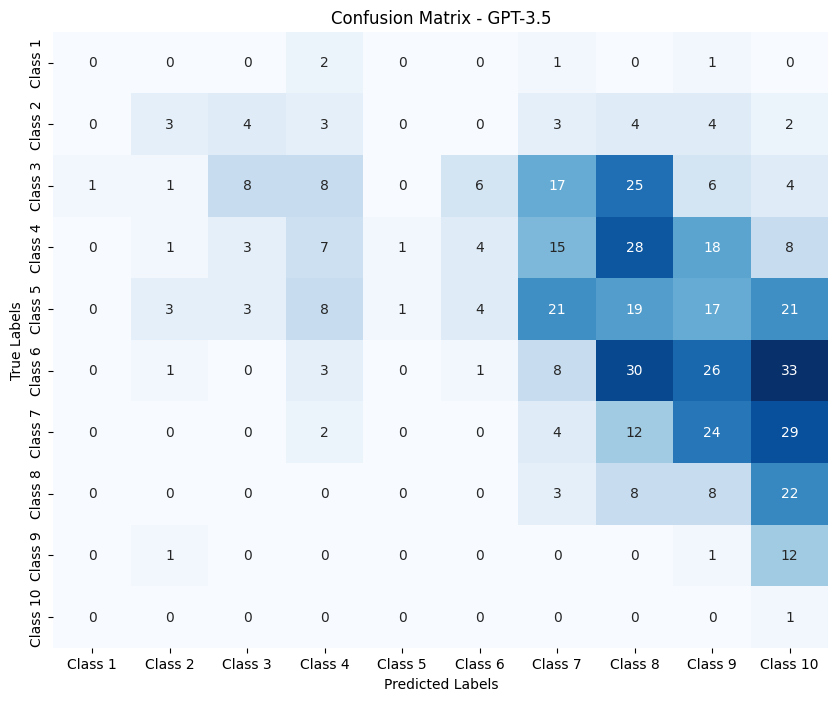

In [109]:
cm = confusion_matrix(ground_truth_scores, gpt_35_scores)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[f"Class {i}" for i in range(1, 11)], 
            yticklabels=[f"Class {i}" for i in range(1, 11)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - GPT-3.5')
plt.show()

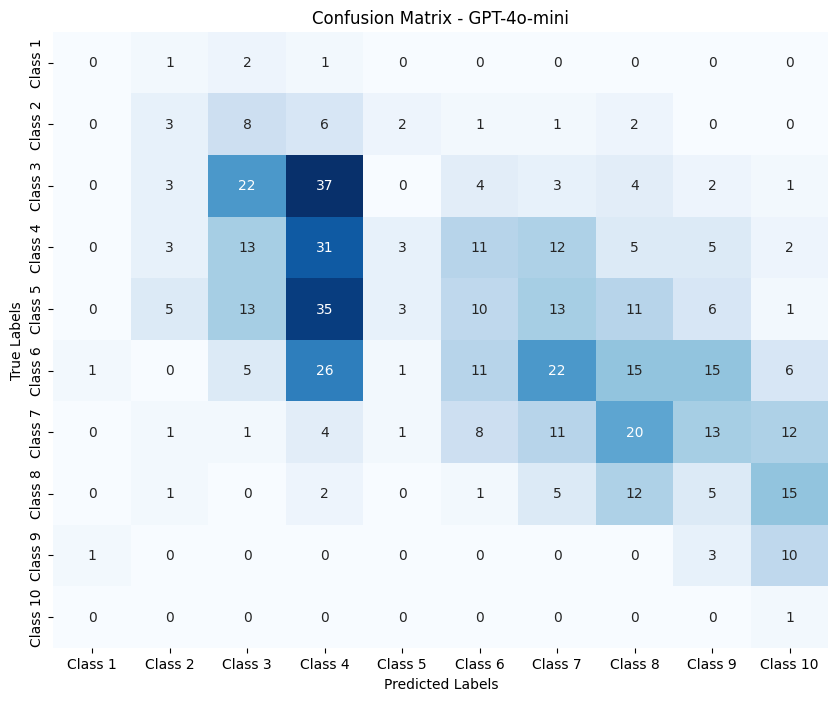

In [110]:
cm = confusion_matrix(ground_truth_scores, gpt_4o_mini_scores)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[f"Class {i}" for i in range(1, 11)], 
            yticklabels=[f"Class {i}" for i in range(1, 11)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - GPT-4o-mini')
plt.show()